##  Optimze and a Dense Neural Network for gap filling and feature identification

** With a few tweaks to RepRunner, an LSTM can be run instead

In [30]:
import time
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import combinations
# from functools import partial
from multiprocessing import Pool
from sklearn import metrics
# from sklearn.model_selection import train_test_split

## Personal Modules
import ReadStandardTimeFill as RSTF
import importlib
import DenseNet as Dense
import MiscFuncs as MF
importlib.reload(Dense)
importlib.reload(RSTF)
importlib.reload(MF)

# %matplotlib inline

%matplotlib notebook
%config IPCompleter.greedy=True

from scipy.optimize import minimize, curve_fit
from scipy.stats import norm
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, WhiteKernel, ConstantKernel
from matplotlib import cm

from scipy import stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison

from ipywidgets import FloatProgress
from IPython.display import display
import os  
from functools import partial
import shutil
from keras import backend as K
try:pool.close()
except:pass


def Test(params,X,y,YScaled,XScaled,pool):
    return(np.random.rand(params['K']))


def ModSelect(Scope,Site):
    if Site == 'Illisarvik':
        if Scope == 'Full':
            Model = ['H','wind_speed','air_pressure','PPFD_Avg','AirTC_Avg','VPD',
                    'Temp','VWC','Sedge','Shrub','Grass','Sparse','Out_of_Basin']
        if Scope == 'Test':
            Model = ['PPFD_Avg','wind_speed','Temp','VWC','Sedge']
    if Site == 'FishIsland':
        BaseFactors = []
        if Scope == 'Full':
            Model = ['H','Wind Spd','air pressure','Ta','Rn','PPFD','Rain','Water Table',
            'Ts 2.5 cm','Ts 15 cm','VWC','Active Layer','24H Rain','Wtr Tbl Trnd']
        if Scope == 'Test':
            Model = ['H','Water Table','Wind Spd','Active Layer']
    return(Model)

def Combos(Model,L,factor=None):
    Models=[]
    for c in combinations(Model,L):
        c = list(c)
        if factor is None:
            Models.append(c)
        else:
            for f in factor:
                f = f.split('+')
                if set(f).issubset(set(c)) and c not in Models:
                    Models.append(c)
                    
    print('Models: ',Models)
    return(Models)

def Stats(mse,j,i,params):
    df = pd.DataFrame(index = [str(j)+'_'+str(i)],
                      data={'Model':[params['Model']],
                            'MSE':[mse.mean()],
                            'SE':[mse.std()/params['K']**.5],
                            'Performance':0})
    return(df)

def t(p,n):
    alpha = 1-p
    df = n-1
    return(stats.t.ppf(alpha,df))


# Model

Models:  [['PPFD_Avg'], ['wind_speed'], ['Temp'], ['VWC'], ['Sedge']]
0.31333333333333335
Epoch 00091: early stopping
Epoch 00163: early stopping
Epoch 00168: early stopping
Saved model to disk
Epoch 00166: early stopping


/home/ubuntu/NetworkAnalysis/DenseNet.py:169: RuntimeWarning: Mean of empty slice
  Y_hat_train_bar=np.nanmean(Y_hat_train,axis=0)


Saved model to disk
0.31333333333333335
Epoch 00007: early stopping
Epoch 00006: early stopping
Epoch 00055: early stopping
Saved model to disk
Epoch 00068: early stopping
Epoch 00027: early stopping
Epoch 00011: early stopping


/home/ubuntu/NetworkAnalysis/DenseNet.py:169: RuntimeWarning: Mean of empty slice
  Y_hat_train_bar=np.nanmean(Y_hat_train,axis=0)


Saved model to disk
0.31333333333333335
Epoch 00006: early stopping
Saved model to disk
Epoch 00013: early stopping
Epoch 00035: early stopping
Epoch 00085: early stopping
Epoch 00036: early stopping
Epoch 00059: early stopping


/home/ubuntu/NetworkAnalysis/DenseNet.py:169: RuntimeWarning: Mean of empty slice
  Y_hat_train_bar=np.nanmean(Y_hat_train,axis=0)


Saved model to disk
0.31333333333333335
Epoch 00006: early stopping
Epoch 00021: early stopping
Epoch 00007: early stopping
Epoch 00057: early stopping
Saved model to disk
Epoch 00027: early stopping
Epoch 00060: early stopping


/home/ubuntu/NetworkAnalysis/DenseNet.py:169: RuntimeWarning: Mean of empty slice
  Y_hat_train_bar=np.nanmean(Y_hat_train,axis=0)


Epoch 00172: early stopping
Saved model to disk
0.31333333333333335
Epoch 00006: early stopping
Epoch 00006: early stopping
Epoch 00028: early stopping
Epoch 00010: early stopping
Epoch 00055: early stopping
Saved model to disk
Epoch 00062: early stopping


/home/ubuntu/NetworkAnalysis/DenseNet.py:169: RuntimeWarning: Mean of empty slice
  Y_hat_train_bar=np.nanmean(Y_hat_train,axis=0)


Epoch 00180: early stopping
Saved model to disk
          MSE       Model  Performance        SE
1_0  0.044658    PPFD_Avg            1  0.003713
1_1  0.281481  wind_speed            0  0.019451
1_2  0.234771        Temp            0  0.020481
1_3  0.276170         VWC            0  0.021451
1_4  0.270370       Sedge            0  0.019212
Models:  [['PPFD_Avg', 'wind_speed'], ['PPFD_Avg', 'Temp'], ['PPFD_Avg', 'VWC'], ['PPFD_Avg', 'Sedge']]
0.31333333333333335
Epoch 00147: early stopping
Epoch 00150: early stopping
Saved model to disk
Epoch 00119: early stopping
Epoch 00134: early stopping


/home/ubuntu/NetworkAnalysis/DenseNet.py:169: RuntimeWarning: Mean of empty slice
  Y_hat_train_bar=np.nanmean(Y_hat_train,axis=0)


Saved model to disk
0.31333333333333335
Epoch 00147: early stopping
Epoch 00165: early stopping
Saved model to disk
Epoch 00195: early stopping
Epoch 00130: early stopping


/home/ubuntu/NetworkAnalysis/DenseNet.py:169: RuntimeWarning: Mean of empty slice
  Y_hat_train_bar=np.nanmean(Y_hat_train,axis=0)


Saved model to disk
0.31333333333333335
Epoch 00086: early stopping
Epoch 00153: early stopping
Epoch 00168: early stopping
Saved model to disk
Epoch 00100: early stopping
Epoch 00166: early stopping
Epoch 00163: early stopping


/home/ubuntu/NetworkAnalysis/DenseNet.py:169: RuntimeWarning: Mean of empty slice
  Y_hat_train_bar=np.nanmean(Y_hat_train,axis=0)


Saved model to disk
0.31333333333333335
Epoch 00138: early stopping
Epoch 00139: early stopping
Saved model to disk
Epoch 00120: early stopping
Epoch 00196: early stopping


/home/ubuntu/NetworkAnalysis/DenseNet.py:169: RuntimeWarning: Mean of empty slice
  Y_hat_train_bar=np.nanmean(Y_hat_train,axis=0)


Saved model to disk
          MSE                Model  Performance        SE
2_0  0.038488  PPFD_Avg+wind_speed            1  0.004033
2_1  0.038230        PPFD_Avg+Temp            1  0.003629
2_2  0.041337         PPFD_Avg+VWC            1  0.003991
2_3  0.039591       PPFD_Avg+Sedge            1  0.003779
Models:  [['PPFD_Avg', 'wind_speed', 'Temp'], ['PPFD_Avg', 'wind_speed', 'VWC'], ['PPFD_Avg', 'wind_speed', 'Sedge'], ['PPFD_Avg', 'Temp', 'VWC'], ['PPFD_Avg', 'Temp', 'Sedge'], ['PPFD_Avg', 'VWC', 'Sedge']]
0.31333333333333335
Epoch 00111: early stopping
Epoch 00153: early stopping
Saved model to disk
Epoch 00136: early stopping
Epoch 00166: early stopping
Epoch 00105: early stopping


/home/ubuntu/NetworkAnalysis/DenseNet.py:169: RuntimeWarning: Mean of empty slice
  Y_hat_train_bar=np.nanmean(Y_hat_train,axis=0)


Saved model to disk
0.31333333333333335
Epoch 00068: early stopping
Epoch 00177: early stopping
Epoch 00095: early stopping
Saved model to disk
Epoch 00163: early stopping
Epoch 00163: early stopping


/home/ubuntu/NetworkAnalysis/DenseNet.py:169: RuntimeWarning: Mean of empty slice
  Y_hat_train_bar=np.nanmean(Y_hat_train,axis=0)


Saved model to disk
0.31333333333333335
Epoch 00131: early stopping
Saved model to disk
Epoch 00125: early stopping
Epoch 00163: early stopping


/home/ubuntu/NetworkAnalysis/DenseNet.py:169: RuntimeWarning: Mean of empty slice
  Y_hat_train_bar=np.nanmean(Y_hat_train,axis=0)


Saved model to disk
0.31333333333333335
Epoch 00074: early stopping
Epoch 00168: early stopping
Epoch 00168: early stopping
Saved model to disk
Epoch 00109: early stopping
Epoch 00166: early stopping
Epoch 00186: early stopping


/home/ubuntu/NetworkAnalysis/DenseNet.py:169: RuntimeWarning: Mean of empty slice
  Y_hat_train_bar=np.nanmean(Y_hat_train,axis=0)


Saved model to disk
0.31333333333333335
Epoch 00130: early stopping
Saved model to disk
Epoch 00129: early stopping
Epoch 00168: early stopping
Epoch 00170: early stopping
Epoch 00195: early stopping


/home/ubuntu/NetworkAnalysis/DenseNet.py:169: RuntimeWarning: Mean of empty slice
  Y_hat_train_bar=np.nanmean(Y_hat_train,axis=0)


Saved model to disk
0.31333333333333335
Epoch 00111: early stopping
Epoch 00173: early stopping
Saved model to disk
Epoch 00193: early stopping
Epoch 00118: early stopping
Epoch 00166: early stopping
Epoch 00197: early stopping


/home/ubuntu/NetworkAnalysis/DenseNet.py:169: RuntimeWarning: Mean of empty slice
  Y_hat_train_bar=np.nanmean(Y_hat_train,axis=0)


Saved model to disk
          MSE                      Model  Performance        SE
3_0  0.035200   PPFD_Avg+wind_speed+Temp            1  0.004151
3_1  0.036933    PPFD_Avg+wind_speed+VWC            1  0.003448
3_2  0.036665  PPFD_Avg+wind_speed+Sedge            1  0.004158
3_3  0.038821          PPFD_Avg+Temp+VWC            1  0.002200
3_4  0.036703        PPFD_Avg+Temp+Sedge            1  0.003399
3_5  0.035466         PPFD_Avg+VWC+Sedge            1  0.003490
Models:  [['PPFD_Avg', 'wind_speed', 'Temp', 'VWC'], ['PPFD_Avg', 'wind_speed', 'Temp', 'Sedge'], ['PPFD_Avg', 'wind_speed', 'VWC', 'Sedge'], ['PPFD_Avg', 'Temp', 'VWC', 'Sedge']]
0.31333333333333335
Epoch 00148: early stopping
Epoch 00155: early stopping
Saved model to disk
Epoch 00105: early stopping
Epoch 00166: early stopping
Epoch 00182: early stopping


/home/ubuntu/NetworkAnalysis/DenseNet.py:169: RuntimeWarning: Mean of empty slice
  Y_hat_train_bar=np.nanmean(Y_hat_train,axis=0)


Saved model to disk
0.31333333333333335
Epoch 00103: early stopping
Saved model to disk
Epoch 00171: early stopping
Epoch 00105: early stopping
Epoch 00166: early stopping


/home/ubuntu/NetworkAnalysis/DenseNet.py:169: RuntimeWarning: Mean of empty slice
  Y_hat_train_bar=np.nanmean(Y_hat_train,axis=0)


Saved model to disk
0.31333333333333335
Epoch 00057: early stopping
Epoch 00108: early stopping
Epoch 00123: early stopping
Saved model to disk
Epoch 00102: early stopping
Epoch 00166: early stopping
Epoch 00161: early stopping


/home/ubuntu/NetworkAnalysis/DenseNet.py:169: RuntimeWarning: Mean of empty slice
  Y_hat_train_bar=np.nanmean(Y_hat_train,axis=0)


Saved model to disk
0.31333333333333335
Epoch 00067: early stopping
Epoch 00113: early stopping
Epoch 00199: early stopping
Saved model to disk
Epoch 00135: early stopping
Epoch 00109: early stopping


/home/ubuntu/NetworkAnalysis/DenseNet.py:169: RuntimeWarning: Mean of empty slice
  Y_hat_train_bar=np.nanmean(Y_hat_train,axis=0)


Saved model to disk
          MSE                           Model  Performance        SE
4_0  0.034211    PPFD_Avg+wind_speed+Temp+VWC            1  0.004979
4_1  0.035043  PPFD_Avg+wind_speed+Temp+Sedge            1  0.004507
4_2  0.042898   PPFD_Avg+wind_speed+VWC+Sedge            1  0.005547
4_3  0.041147         PPFD_Avg+Temp+VWC+Sedge            1  0.006523
Models:  [['PPFD_Avg', 'wind_speed', 'Temp', 'VWC', 'Sedge']]
0.31333333333333335
Epoch 00163: early stopping
Epoch 00197: early stopping
Saved model to disk
Epoch 00195: early stopping
Epoch 00106: early stopping


/home/ubuntu/NetworkAnalysis/DenseNet.py:169: RuntimeWarning: Mean of empty slice
  Y_hat_train_bar=np.nanmean(Y_hat_train,axis=0)


Saved model to disk
          MSE                               Model  Performance        SE
5_0  0.035241  PPFD_Avg+wind_speed+Temp+VWC+Sedge            1  0.003401
Models:  []
          MSE                               Model  Performance        SE
5_0  0.035241  PPFD_Avg+wind_speed+Temp+VWC+Sedge            1  0.003401


<IPython.core.display.Javascript object>


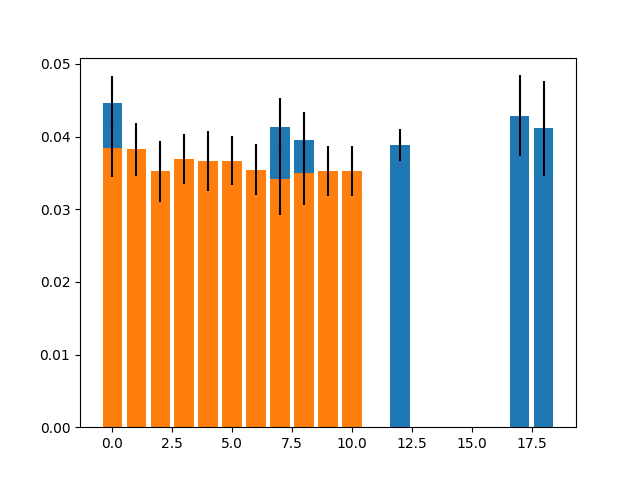

0.0386439694609
RangeIndex(start=0, stop=11, step=1) 0     0.038488
1     0.038230
2     0.035200
3     0.036933
4     0.036665
5     0.036703
6     0.035466
7     0.034211
8     0.035043
9     0.035241
10    0.035241
Name: MSE, dtype: float64 0     0.004033
1     0.003629
2     0.004151
3     0.003448
4     0.004158
5     0.003399
6     0.003490
7     0.004979
8     0.004507
9     0.003401
10    0.003401
Name: SE, dtype: float64
   index       MSE                               Model  Performance        SE
0    1_0  0.044658                            PPFD_Avg            1  0.003713
1    1_1  0.281481                          wind_speed            0  0.019451
2    1_2  0.234771                                Temp            0  0.020481
3    1_3  0.276170                                 VWC            0  0.021451
4    1_4  0.270370                               Sedge            0  0.019212
5    2_0  0.038488                 PPFD_Avg+wind_speed            2  0.004033
6    2_1  0.038230  

In [31]:
MP=True
Scope = 'Test'
cwd = os.getcwd()
# for Site in ['Illisarvik','FishIsland']:
Site='Illisarvik'
target='fco2'

# params['Loss']='mean_absolute_error'

if __name__ == '__main__':
    XVarriables=ModSelect(Scope,Site)
    for j in range(1,len(XVarriables)+2):
        if j == 1:
            Inputs = (Combos(XVarriables,j))
        else:
            Inputs = (Combos(XVarriables,j,Factors))
        i = 0
        for Input in Inputs:
            params = Dense.Params(Scope,target,MP)
            params['Dpath'] = cwd+'/'+Site+'/'
            params['Spath'] = params['Dpath']+'/'+target+'/'+str(j)+'_'+str(i)+'/'
            try:
                os.mkdir(params['Spath'])
            except:
                pass
            params['Sname'] = 'Y_'
            params['Inputs'] = Input
            params['Model'] = '+'.join(params['Inputs'])

            RST = RSTF.ReadStandardTimeFill(params['Dpath']+'ECData.csv',resample='2H')
            RST.Scale(params['target'],params['Inputs'])
            y = RST.y*1.0
            X = RST.X*1.0

            params['N']=int(y.shape[0]/30)
#             mse = Test(params,X,y,RST.YScaled,RST.XScaled,pool)
            params['Memory'] = (math.floor(100/params['proc'])- 5/params['proc']) * .01
            print(params['Memory'])
            Y_hat=[]
            y_true=[]
            X_true=[]
            index=[]
            ones=[]
            if MP == False:
                for k in range(params['K']):
                    results = Dense.TTV_Split(k,params,X,y)
                    Y_hat.append(RST.YScaled.inverse_transform(results[0]))
                    y_true.append(RST.YScaled.inverse_transform(results[1]))
                    X_true.append(RST.XScaled.inverse_transform(results[2]))
                    index.append(results[3])
                    ones.append(results[4])
            else:
                pool = Pool(processes=3,maxtasksperchild=75)
                for k,results in enumerate(pool.imap(partial(Dense.TTV_Split,params=params,X=X,y=y),range(params['K']))):
                    Y_hat.append(RST.YScaled.inverse_transform(results[0]))
                    y_true.append(RST.YScaled.inverse_transform(results[1]))
                    X_true.append(RST.XScaled.inverse_transform(results[2]))
                    index.append(results[3])
                    ones.append(results[4])
                pool.close()
                
#                 tf.keras.backend.clear_session()
            Y_hat = np.squeeze(np.asanyarray(Y_hat))
            y_true = np.squeeze(np.asanyarray(y_true))
            X_true = np.asanyarray(X_true)
            index = np.asanyarray(index)
            ones = np.asanyarray(ones)
            
            if MP == False:
                for k in range(1):
                     mse = Dense.Sort_outputs(k,params,Y_hat,y_true,X_true,index,ones)
            else:
                pool = Pool(processes=1,maxtasksperchild=75)
                for k,results in enumerate(pool.imap(partial(Dense.Sort_outputs,params=params,
                                                             Y_hat=Y_hat,y_true=y_true,X_true=X_true,index=index,ones=ones),
                                                     range(1))):
                     mse = results
                pool.close()
            
            if i == 0:
                Level = Stats(mse,j,i,params)
            else:
                Level = Level.append(Stats(mse,j,i,params))
            i += 1

        Min = Level.loc[Level['MSE']==Level['MSE']].min()
        T= t(0.05,params['K'])
        Factors = Level.loc[Level['MSE']<=Min['MSE']+Min['SE']*T,'Model'].values
        Level.loc[Level['MSE']<=Min['MSE']+Min['SE']*T,'Performance']=1
        print(Level)
        
        if j == 1:
            Records = Level
        else:
            Records = Records.append(Level)


Records = Records.reset_index()
plt.figure()
Min = Records.loc[Records['MSE']==Records['MSE']].min()
print(Min['MSE']+Min['SE']*T)
Records.loc[Records['MSE']<=Min['MSE']+Min['SE']*T,'Performance']=2
T= t(0.05,params['K'])
Top = Records.loc[Records['Performance']==1]

Worst = Records.loc[Records['Performance']==0].index.values
# for rm in Worst:
#     shutil.rmtree(params['Dpath']+'/'+target+'/'+rm)
Best = Records.loc[Records['Performance']==2]#.reset_index()
print(Best.index,Best['MSE'],Best['SE'])
plt.bar(Top.index,Top['MSE'],yerr=Top['SE'])
plt.bar(Best.index,Best['MSE'],yerr=Best['SE'])#,color='red')
print(Records)

<IPython.core.display.Javascript object>


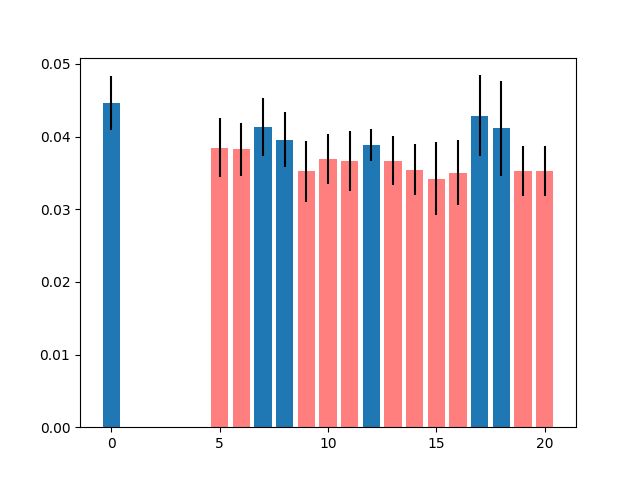

0.0386439694609
Int64Index([5, 6, 9, 10, 11, 13, 14, 15, 16, 19, 20], dtype='int64') 5     0.038488
6     0.038230
9     0.035200
10    0.036933
11    0.036665
13    0.036703
14    0.035466
15    0.034211
16    0.035043
19    0.035241
20    0.035241
Name: MSE, dtype: float64 5     0.004033
6     0.003629
9     0.004151
10    0.003448
11    0.004158
13    0.003399
14    0.003490
15    0.004979
16    0.004507
19    0.003401
20    0.003401
Name: SE, dtype: float64
   index       MSE                               Model  Performance        SE
0    1_0  0.044658                            PPFD_Avg            1  0.003713
1    1_1  0.281481                          wind_speed            0  0.019451
2    1_2  0.234771                                Temp            0  0.020481
3    1_3  0.276170                                 VWC            0  0.021451
4    1_4  0.270370                               Sedge            0  0.019212
5    2_0  0.038488                 PPFD_Avg+wind_speed            

In [33]:

plt.figure()
Min = Records.loc[Records['MSE']==Records['MSE']].min()
print(Min['MSE']+Min['SE']*T)
Records.loc[Records['MSE']<=Min['MSE']+Min['SE']*T,'Performance']=2
T= t(0.05,params['K'])
Top = Records.loc[Records['Performance']==1]

Worst = Records.loc[Records['Performance']==0].index.values
# for rm in Worst:
#     shutil.rmtree(params['Dpath']+'/'+target+'/'+rm)
Best = Records.loc[Records['Performance']==2]#.reset_index()
print(Best.index,Best['MSE'],Best['SE'])
plt.bar(Top.index,Top['MSE'],yerr=Top['SE'])
plt.bar(Best.index,Best['MSE'],yerr=Best['SE'],color='red',alpha=.5)
print(Records)

# Sorting

# CI and PI

# Map Results

In [ ]:
Fill = False
if Fill == True:
    X = RST.X_fill
else:
    X = RST.X
print(X.shape)
params['Sname']='Test'
params['Loss']='mean_absolute_error'
Y_fill = []
Y_bar = []
MSE = []
for i in range(params['K']):
    params['iteration']=i
    Empty_Mod = Dense.Load_Model(params)
    Model = Dense.Load_Weights(Empty_Mod,params) 
    Y = RST.YScaled.inverse_transform(Model.predict(X).reshape(-1,1))
    Y_bar.append(RST.YScaled.inverse_transform(Model.predict(np.median(X,axis=0)).reshape(-1,1)))
    if Fill == False:
        mse = (metrics.mean_squared_error(RST.y,Y))
        MSE.append(mse)
    Y_fill.append(Y)
Y_fill = np.asanyarray(Y_fill).mean(axis=-1)
Y_bar = np.asanyarray(Y_bar).mean(axis=-1)
Y_fill_bar = Y_fill.mean(axis=0)
Y_bar = Y_bar.mean(axis=0)
if Fill == False:
    MSE = np.asanyarray(MSE)
    CI = stats.t.ppf(1-0.025,i)*MSE.std()/(i)**.5
    print(CI)
    
print(Y_bar,Y_fill_bar.mean())

params['Sname']='Var'
params['iteration']=1
params['Loss']='Boot_Loss'
Empty_Mod = Dense.Load_Model(params)
Model = Dense.Load_Weights(Empty_Mod,params) 
YVar=YScaled.inverse_transform(Model.predict(X).reshape(-1,1))
YVar_bar=YScaled.inverse_transform(Model.predict(X.mean(axis=0)).reshape(-1,1))
X_back = np.squeeze(RST.XScaled.inverse_transform(X))

print(RST.YScaled.inverse_transform(RST.y).shape,np.squeeze(Y_fill_bar).shape)

Data = pd.DataFrame(data=X_back,columns=params['Inputs'])
Data[target] = np.squeeze(Y_fill_bar)
Data['True'] = RST.Master[target]#.YScaled.inverse_transform(RST.y)
Data['SE'] = 1/(params['K']-1)*((Y_fill-Y_fill_bar)**2).sum(axis=0)
Data['Var'] = np.squeeze(YVar)
Data['CI']=stats.t.ppf(1-0.025,params['K'])*(Data['SE'])**.5
Data['PI']=stats.t.ppf(1-0.025,params['K'])*((Data['Var']+Data['SE'])**.5) #the accuracy of our estimate with respect to the observed output

print(Data['CI'].mean())
print(Data[target].mean())
print(Data['True'].mean())
Data['Fill'] = Data['True'].fillna(Data[target])
print(Data['Fill'].mean())

# plt.figure(figsize=(8,7))
# Data = Data.sort_values(by='PPFD_Avg')
# Data.index = Data.PPFD_Avg


# plt.scatter(Data.index,Data['True'],edgecolor='black',facecolor='white')
# plt.plot(Data.index,Data[target],label=
#         params['target']+' Model\nRMSE: '+str(np.round(metrics.r2_score(Data['True'],
#                                                                    Data[params['target']])**2,3)))
# # plt.plot(Data.index,Data['Var'],label= params['target']+
# # ' Model\nRMSE: '+str(np.round(metrics.mean_squared_error(Data['True'],
# #                                                                    Data[params['target']])**2,3)))


# plt.fill_between(Data.index, Data[target]-Data['PI'], 
#                  Data[target]+Data['PI'],  color = 'green', alpha = 0.4, 
#                  label = '95% PI')
# plt.fill_between(Data.index, Data[target]-Data['CI'], 
#                  Data[target]+Data['CI'],  color = 'red', alpha = 0.4, 
#                  label = '95% CI')
# plt.legend()

# The "Optimum" Sized Model

In [ ]:
# pool.close()
# Site = 'Illisarvik'#'FishIsland'#
Scope = 'Test'
cwd = os.getcwd()

# def Params(Func,Y,MP = True):
#     params = {}
#     params['proc']=3
#     if MP == False:
#         params['proc']=1
#     if Func == 'Full':
#         epochs = 200
#         K = 30
#         splits_per_mod = 1
#         N = np.linspace(200,20,10,dtype='int32')
#     elif Func == 'Test':
#         epochs = 200
#         K = 30
#         splits_per_mod = 1
#         N = np.linspace(70,10,5,dtype='int32')
#     N = np.repeat(N,K)
#     d = {'N':N.astype(int)}
#     Runs = pd.DataFrame(data=d)
#     Runs['MAE'] = 0.0
#     Runs['R2'] = 0.0
#     Runs['Model']=0
#     params['K'] = K
#     params['epochs'] = epochs
#     params['Y'] = Y
#     params['splits_per_mod'] = splits_per_mod
#     params['Save'] = {}
#     params['Save']['Weights']=False
#     params['Save']['Model']=False
    
#     return(Runs,params)


# MP=False

# if Scope == 'Full':
#     MP = True
# if __name__=='__main__'and MP==True:
#     pool = Pool(processes=3,maxtasksperchild=75)
# else:pool=None
    
# # for Site in ['Illisarvik','FishIsland']:
# Site='Illisarvik'
# FillVar = 'fco2'
# #     for FillVar in ['fco2','fch4']:
# Runs,params = MF.Params(Scope,FillVar,MP)
# FullModel = ModSelect(Scope,Site)
# print(FullModel)
# params['Dpath'] = cwd+'/'+Site+'/'
# params['Prelim_N']=True
# Best,Scores,ModelRuns = MF.FactorTest(params,FullModel,Runs)
# print(Best,Scores)
# Scores,ModelRuns = Best_Fill(Best,Runs,Scores,params)
# Scores.to_csv(params['Dpath']+FillVar+'/GapFillingSummary.csv')
# ModelRuns.to_csv(params['Dpath']+FillVar+'/GapFilled.csv')

# if __name__=='__main__'and MP==True:
#     pool.close()

In [ ]:
# Grp = Scores.groupby('Model').mean()
# Grp['SE'] = Scores[['Model','MAE']].groupby('Model').sem()
# # Grp['SE'] = Scores[['Key','MAE']].groupby('Key').sem()
# print(Grp)
# # plt.bar(Grp.index,Grp['MAE'],yerr=Grp['SE'])

In [ ]:
print('kitty')